# Run ctrl vs stim DC

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig5/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [6]:
# adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69958, 36601)

In [8]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [9]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])
# adata_processed.obs['ct'] = adata_processed.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [10]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [11]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [12]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

Version 0.0.6


### Define ISG classes

In [110]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [111]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [112]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Control TF correlations for type 1 ISGs

In [113]:
ct = ['C']
adata_ctrl = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()

adata_ctrl.obs['group'] = 1
memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

available_genes = adata_ctrl.var.index.tolist()
available_tfs = list(set(tf_list) & set(available_genes))
available_isgs = list(set(available_genes) & set(all_isg))

print(len(available_tfs), len(available_isgs))

memento.compute_2d_moments(adata_ctrl, list(itertools.product(available_tfs, available_isgs)))


ctrl_moments = memento.get_2d_moments(adata_ctrl, groupby='group')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


618 342


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [114]:
df = []
for tf in available_tfs:
    pv = stats.ttest_1samp(ctrl_moments.query('gene_1 == "{}"'.format(tf)).dropna()['group_1'].values, popmean=0)[1]
    corr = ctrl_moments.query('gene_1 == "{}"'.format(tf)).dropna()['group_1'].values.mean()
    df.append((tf, corr, pv))    
    
df = pd.DataFrame(df, columns=['tf','corr', 'pv'])

In [115]:
df['log10(P)'] = -np.log10(df['pv'])

In [116]:
df.sort_values('log10(P)', ascending=False).head(10)

,tf,corr,pv,log10(P)
441,STAT1,0.285828,2.948345e-71,70.530422
608,SP110,0.293909,3.509568e-70,69.454746
299,IRF7,0.271833,9.847754e-59,58.006663
323,SP100,0.288822,1.052640e-56,55.977720
138,IRF6,0.199167,1.110840e-54,53.954348
286,CEBPB,0.176451,3.778957e-52,51.422628
467,LRRFIP1,0.160874,3.827560e-50,49.417078
17,IRF9,0.207119,6.621649e-50,49.179034
187,GTF2I,0.156575,1.673428e-49,48.776393
597,ETV7,0.285261,4.491474e-49,48.347611


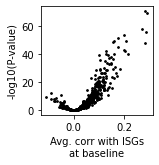

In [117]:
plt.figure(figsize=(2,2))
plt.scatter(df['corr'], df['log10(P)'], s=3, color='k')
plt.xlabel('Avg. corr with ISGs\nat baseline'); plt.ylabel('-log10(P-value)')
plt.savefig('control_tf_volcano.png', bbox_inches='tight', dpi=1000)

### Change in correlation in response to IFNs

- Canonical: STAT1, STAT2, IRF1, IRF7, IRF9
- IFNB: RELA, REL, JUN, HBP1, JUNB, KLF5, JUN
- IFNG: 

In [118]:
def get_2d_ht(stim):
    
    adata_stim = adata.copy()[
        adata.obs.ct.isin(['C']) & \
        adata.obs.time.isin(['0', '3'])& \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, 3:1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    
    available_tfs = list(set(tf_list) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list(set(available_genes) & set(all_isg))
            
    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
    
#     memento.ht_2d_moments( 
#         adata_stim, 
#         formula_like='1 + time_step',
#         treatment_col='time_step', 
#         num_boot=100, 
#         approx=False,
#         resampling='permutation',
#         verbose=1,
#         num_cpus=92)
    
    return available_tfs, memento.get_2d_moments(adata_stim, groupby='time_step')

In [119]:
available_tfs, beta_result = get_2d_ht('beta')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [120]:
beta_result['diff'] = beta_result['time_step_1'] - beta_result['time_step_0']

In [121]:
df = []
for tf in available_tfs:
    pv = stats.ttest_1samp(beta_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values, popmean=0)[1]
    corr = beta_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values.mean()
    df.append((tf, corr, pv))    
    
df = pd.DataFrame(df, columns=['tf','corr', 'pv'])

In [122]:
result_1d = memento.get_1d_ht_result(sc.read(data_path + 'binary_test_latest/C_beta_3.h5ad'))
result_1d['de_fdr'] = memento.util._fdrcorrect(result_1d['de_pval'])
result_1d.index = result_1d['gene']

In [123]:
df['log10(P)'] = -np.log10(df['pv'])
df.index = df['tf']
df = df.join(result_1d).sort_values('pv')[['tf', 'corr', 'pv', 'log10(P)', 'de_fdr']]#.head(20)

In [124]:
df.sort_values('corr', ascending=False).head(15)

,tf,corr,pv,log10(P),de_fdr
tf,,,,,
HBP1,HBP1,0.192938,3.112031e-65,64.506956,1.763326e-01
USF2,USF2,0.162759,4.980617e-50,49.302717,1.005752e-01
RELA,RELA,0.160893,6.371824e-47,46.195736,7.420385e-01
ZBTB24,ZBTB24,0.143017,1.724705e-45,44.763285,3.494519e-01
MEF2A,MEF2A,0.141422,6.865805e-43,42.163309,5.532377e-02
FIZ1,FIZ1,0.141328,2.010290e-33,32.696741,3.374987e-01
ARID4B,ARID4B,0.138592,1.182041e-38,37.927367,9.748953e-06
PITX1,PITX1,0.136217,2.707235e-58,57.567474,7.738138e-01
ADNP,ADNP,0.134710,3.238395e-40,39.489670,1.634082e-01


In [125]:
df.sort_values('pv').head(10)

,tf,corr,pv,log10(P),de_fdr
tf,,,,,
HBP1,HBP1,0.192938,3.112031e-65,64.506956,1.763326e-01
JUNB,JUNB,0.105625,2.993046e-59,58.523887,1.479046e-21
PITX1,PITX1,0.136217,2.707235e-58,57.567474,7.738138e-01
HES4,HES4,0.108879,3.673743e-58,57.434891,1.245478e-51
ELF3,ELF3,0.099873,6.141892e-58,57.211698,2.606274e-14
KLF6,KLF6,0.095742,1.435928e-54,53.842867,4.398774e-04
KLF5,KLF5,0.115576,1.901505e-53,52.720903,4.296872e-01
JUN,JUN,0.081708,2.515074e-53,52.599449,2.381875e-05
ID1,ID1,0.096838,4.259017e-53,52.370691,1.325855e-21


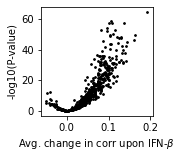

In [126]:
plt.figure(figsize=(2,2))
plt.scatter(df['corr'], df['log10(P)'], s=3, color='k')
# plt.scatter(df.loc['REL']['corr'], df.loc['REL']['log10(P)'], s=100, color='orange')

plt.xlabel(r'Avg. change in corr upon IFN-$\beta$'); plt.ylabel('-log10(P-value)')
plt.savefig('beta_tf_volcano.png', bbox_inches='tight', dpi=1000)

In [32]:
available_tfs, gamma_result = get_2d_ht('gamma')
gamma_result['diff'] = gamma_result['time_step_1'] - gamma_result['time_step_0']

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [231]:
df = []
for tf in available_tfs:
    pv = stats.ttest_1samp(gamma_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values, popmean=0)[1]
    corr = gamma_result.query('gene_1 == "{}"'.format(tf)).dropna()['diff'].values.mean()
    df.append((tf, corr, pv))    
    
df = pd.DataFrame(df, columns=['tf','corr', 'pv'])

In [232]:
result_1d = memento.get_1d_ht_result(sc.read(data_path + 'binary_test_latest/C_gamma_3.h5ad'))
result_1d['de_fdr'] = memento.util._fdrcorrect(result_1d['de_pval'])
result_1d.index = result_1d['gene']

In [233]:
df['log10(P)'] = -np.log10(df['pv'])
df.index = df['tf']
df = df.join(result_1d).sort_values('pv')[['tf', 'corr', 'pv', 'log10(P)', 'de_fdr']]#.head(20)

In [234]:
'ATF2' in tf_list

True

In [235]:
df.loc['STAT3']

tf              STAT3
corr         0.059418
pv                0.0
log10(P)    14.723426
de_fdr       0.356756
Name: STAT3, dtype: object

In [237]:
df.sort_values('corr', ascending=False).head(15)

,tf,corr,pv,log10(P),de_fdr
tf,,,,,
ZNF384,ZNF384,0.095584,2.769248e-21,20.557638,0.708365
MBD4,MBD4,0.090066,1.180807e-29,28.927821,0.721298
FIZ1,FIZ1,0.083779,1.718973e-11,10.764731,0.194032
IKZF5,IKZF5,0.081786,2.602865e-14,13.584548,0.876870
ZNF592,ZNF592,0.079325,4.849368e-19,18.314315,0.724071
ZNF429,ZNF429,0.074542,1.524062e-14,13.816997,0.160588
ZNF644,ZNF644,0.070284,5.152618e-20,19.287972,0.397336
HMGXB4,HMGXB4,0.068485,9.740400e-20,19.011423,0.804845
ARID4B,ARID4B,0.066790,7.806235e-12,11.107558,0.003989


In [239]:
df.sort_values('pv').head(10)

,tf,corr,pv,log10(P),de_fdr
tf,,,,,
MBD4,MBD4,0.090066,1.180807e-29,28.927821,7.212978e-01
JUN,JUN,0.046286,4.547175e-28,27.342258,1.622893e-01
HMGB1,HMGB1,0.061753,3.092728e-25,24.509658,2.419183e-01
YBX1,YBX1,0.052585,4.433267e-23,22.353276,4.522344e-16
SOX4,SOX4,0.039495,1.552703e-22,21.808912,3.435722e-04
ID4,ID4,0.053447,2.260245e-22,21.645845,4.734399e-01
TGIF1,TGIF1,0.060359,2.437495e-22,21.613056,3.881408e-02
ZNF211,ZNF211,-0.079505,2.649234e-22,21.576880,9.698392e-01
ZBTB20,ZBTB20,-0.058685,1.191161e-21,20.924029,3.284058e-03


Text(0, 0.5, '-log10(P-value)')

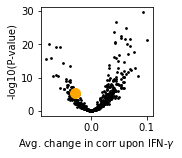

In [172]:
plt.figure(figsize=(2,2))
plt.scatter(df['corr'], df['log10(P)'], s=3, color='k')
plt.scatter(df.loc['STAT1']['corr'], df.loc['STAT1']['log10(P)'], s=100, color='orange')

plt.xlabel(r'Avg. change in corr upon IFN-$\gamma$'); plt.ylabel('-log10(P-value)')

### DC genes with non-canonical regulators

In [20]:
tfs = 'STAT1, STAT2, IRF1, IRF7, IRF9, STAT3'.split(', ')# + 'RELA, REL, JUN, HBP1, JUNB, KLF5'.split(', ') + ['FOS', 'CREB1', 'MYC', 'MBD4', 'HMGB1', 'IKZF5', 'YBX1']

In [36]:
def get_2d_ht_filtered(stim):
    
    adata_stim = adata.copy()[
        adata.obs.ct.isin(['C']) & \
        adata.obs.time.isin(['0', '3'])& \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, 3:1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    
    available_tfs = list(set(tfs) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list(set(available_genes) & set(all_isg))
            
    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        treatment_col='time_step', 
        num_boot=20000, 
        approx=True,
        resampling='bootstrap',
        verbose=1,
        num_cpus=92)
    
    
    return adata_stim.copy()

In [37]:
beta_adata = get_2d_ht_filtered('beta')
beta_ht = memento.get_2d_ht_result(beta_adata)
beta_ht['corr_fdr'] = memento.util._fdrcorrect(beta_ht['corr_pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:   17.3s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   35.7s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   55.1s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 2025 out of 2025 | elapsed:  1.6min finished


In [38]:
gamma_adata = get_2d_ht_filtered('gamma')
gamma_ht = memento.get_2d_ht_result(gamma_adata)
gamma_ht['corr_fdr'] = memento.util._fdrcorrect(gamma_ht['corr_pval'])

[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    8.9s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   23.2s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   39.5s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:  1.0min
[Parallel(n_jobs=92)]: Done 1995 out of 1995 | elapsed:  1.3min finished


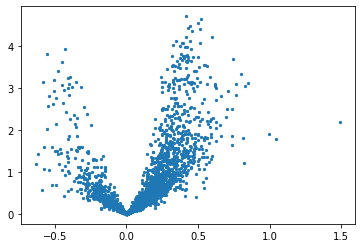

In [42]:
plt.scatter(beta_ht['corr_coef'], -np.log10(beta_ht['corr_pval']), s=5)

In [54]:
beta_ht.query('gene_1 == "STAT1" & gene_2 == "ISG15"', engine='python')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
557,STAT1,ISG15,-0.043599,0.072437,0.541823,0.790693


In [61]:
gamma_ht.query('gene_1 == "STAT1"  & corr_coef > 0').sort_values('corr_pval').head(50)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
552,STAT1,CD74,0.383656,0.087809,0.000212,0.040821
435,STAT1,PLAAT4,0.361927,0.083666,0.000259,0.040821
368,STAT1,HLA-DRA,0.328784,0.082367,0.000419,0.044170
461,STAT1,HLA-DRB1,0.336106,0.090270,0.000600,0.052302
345,STAT1,CXCL17,0.300958,0.084233,0.000735,0.053071
430,STAT1,HLA-DQB1,0.418180,0.130441,0.001250,0.062653
358,STAT1,HLA-DPB1,0.318539,0.108498,0.003950,0.114773
344,STAT1,GBP3,0.447210,0.156731,0.004850,0.126283
510,STAT1,MSRB1,0.451126,0.159584,0.006700,0.152646
402,STAT1,MT1E,0.282058,0.104353,0.008150,0.160006


In [72]:
beta_ht['es_abs'] = beta_ht['corr_coef'].abs()

In [103]:
beta_ht.query('gene_1 == "STAT1"').sort_values('es_abs').head(20)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,es_abs
454,STAT1,IFIT1,-0.001850,0.074548,0.979301,0.993140,0.001850
379,STAT1,CASP7,0.001957,0.186797,0.992150,0.996066,0.001957
653,STAT1,OAS2,-0.004707,0.088101,0.960602,0.985705,0.004707
494,STAT1,LAP3,-0.004798,0.086109,0.956852,0.984924,0.004798
663,STAT1,APOD,-0.005163,0.094776,0.956602,0.984924,0.005163
345,STAT1,PLSCR1,-0.007496,0.082078,0.927354,0.977952,0.007496
342,STAT1,GBP5,0.007926,0.191268,0.966352,0.987212,0.007926
376,STAT1,SLC25A25,0.008872,0.146738,0.950902,0.984516,0.008872
528,STAT1,MX1,-0.009447,0.065655,0.885756,0.957688,0.009447
430,STAT1,ZC3HAV1,0.010512,0.105901,0.920904,0.975470,0.010512


In [76]:
beta_ht.query('gene_1 == "STAT1"').sort_values('corr_pval').head(5)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr,es_abs
631,STAT1,TXNIP,0.418252,0.069147,0.000019,0.011835,0.418252
612,STAT1,HLA-A,0.427994,0.085072,0.000037,0.011835,0.427994
370,STAT1,HLA-B,0.396924,0.080275,0.000083,0.011835,0.396924
442,STAT1,PLAAT4,0.388132,0.071479,0.000085,0.011835,0.388132
515,STAT1,B2M,0.316373,0.069431,0.000175,0.012223,0.316373


### Changes in coexpression with canonical regulators

In [37]:
def get_moments_tp(stim):
    adata_stim = adata.copy()[
        adata.obs.ct.isin(['C']) & \
        adata.obs.stim.isin([stim, 'control'])].copy()
    time_converter={0:0, 3:1, 6:2, 9:3, 24:4, 48:5}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time_step', 'donor', 'ct'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)

    available_tfs = list(set(tfs) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list(set(available_genes) & set(all_isg))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_isgs)))
    moments = memento.get_2d_moments(adata_stim, groupby='time_step')[['gene_1', 'gene_2'] + ['time_step_'+str(i) for i in range(6)]]
    
    return moments

In [41]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
moments = {stim:get_moments_tp(stim) for stim in stims}

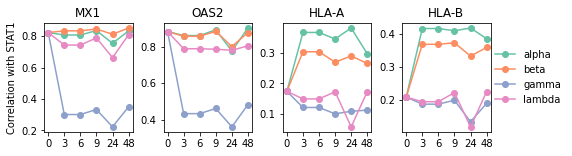

In [104]:
matplotlib.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.Set2.colors)
plt.figure(figsize=(8,2))
plt.subplots_adjust(wspace=0.35)

genes = ['MX1', 'OAS2', 'HLA-A', 'HLA-B']
for idx, g in enumerate(genes):
    


    plt.subplot(1, 4, idx+1)
    for stim in stims:
        plt.plot(moments[stim].query('gene_2 == "{}"'.format(g)).iloc[0,2:].values, '-o')
    plt.xticks(list(range(6)), ['0', '3', '6', '9', '24', '48'])
    
    if idx == 0:
        plt.ylabel('Correlation with STAT1')
    plt.title(g)

plt.legend(stims, ncol=1, bbox_to_anchor=(1.9, 0.5),loc='right', frameon=False)
plt.savefig('stat1_corr_time.pdf', bbox_inches='tight')

In [34]:
a = ['MX1', 'IFIT1', 'OAS2']
b = ['HLA-A', 'HLA-B', 'HLA-C']
# b = ['HLA-DRA', 'HLA-DQB1', 'CD74']

In [35]:
moments.query('gene_2 in @a')

,gene_1,gene_2,time_step_0,time_step_1,time_step_2,time_step_3,time_step_4,time_step_5
290,STAT1,MX1,0.823479,0.834524,0.834524,0.846172,0.812806,0.852446
306,STAT1,OAS2,0.883080,0.856975,0.856975,0.884426,0.800899,0.877441
642,STAT1,IFIT1,0.756889,0.762110,0.762110,0.784964,0.717362,0.784660


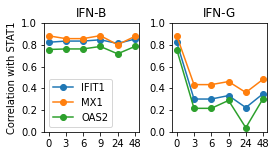

In [36]:
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.35)
plt.subplot(1, 2, 1)
data = moments.query('gene_2 in @a').iloc[:, 2:].values
plt.plot(data.T, '-o')
plt.legend(['IFIT1', 'MX1', 'OAS2'])
plt.ylim(0, 1)
plt.ylabel('Correlation with STAT1')
plt.xticks(list(range(6)), ['0', '3', '6', '9', '24', '48'])
plt.title('IFN-B')
plt.subplot(1, 2, 2)
data = gamma_moments.query('gene_2 in @a').iloc[:, 2:].values
plt.plot(data.T, '-o')
plt.ylim(0, 1)
plt.xticks(list(range(6)), ['0', '3', '6', '9', '24', '48'])
plt.title('IFN-G')

plt.savefig('t1_isg_time.pdf', bbox_inches='tight')

In [140]:
moments.query('gene_2 in @b')

,gene_1,gene_2,time_step_0,time_step_1,time_step_2,time_step_3,time_step_4,time_step_5
33,STAT1,HLA-B,0.207904,0.369291,0.369291,0.374005,0.333319,0.359679
298,STAT1,HLA-A,0.174044,0.304274,0.304274,0.269991,0.290384,0.265853
305,STAT1,HLA-C,0.320169,0.502111,0.502111,0.531234,0.462964,0.510162


In [141]:
gamma_moments.query('gene_2 in @b')

,gene_1,gene_2,time_step_0,time_step_1,time_step_2,time_step_3,time_step_4,time_step_5
32,STAT1,HLA-B,0.207904,0.186293,0.186293,0.198392,0.132347,0.188808
280,STAT1,HLA-A,0.174044,0.120885,0.120885,0.099905,0.108419,0.112171
287,STAT1,HLA-C,0.320169,0.215971,0.215971,0.225310,0.124698,0.226245


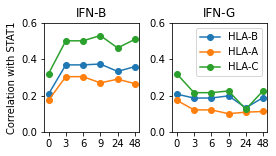

In [143]:
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.35)
plt.subplot(1, 2, 1)
data = moments.query('gene_2 in @b').iloc[:, 2:].values
plt.plot(data.T, '-o')
plt.ylim(0, 0.6)
plt.ylabel('Correlation with STAT1')
plt.xticks(list(range(6)), ['0', '3', '6', '9', '24', '48'])
plt.title('IFN-B')
plt.subplot(1, 2, 2)
data = gamma_moments.query('gene_2 in @b').iloc[:, 2:].values
plt.plot(data.T, '-o')
plt.ylim(0, 0.6)
plt.xticks(list(range(6)), ['0', '3', '6', '9', '24', '48'])
plt.title('IFN-G')
plt.legend(['HLA-B', 'HLA-A', 'HLA-C'])

plt.savefig('other_isg_time.pdf', bbox_inches='tight')

### Detect differences between type 1 and type 2 IFNs

In [76]:
'MTOR' in tf_list

False

In [258]:
tfs = 'STAT1, STAT2, IRF1, IRF7, IRF9, STAT3'.split(', ') + 'RELA, REL, JUN, HBP1, JUNB, KLF5'.split(', ') + ['FOS', 'CREB1', 'MYC', 'MBD4', 'HMGB1', 'IKZF5', 'YBX1']
# tfs = ['JAK1', 'JAK2', 'MAPK14', 'STAT5A']

In [279]:
plt.figure(figsize=(30,20))
tps = ['3', '6', '9', '24', '48']
for idx, tp in enumerate(tps):

    adata_stim = adata.copy()[
        adata.obs.ct.isin(['C']) & \
        adata.obs.time.isin(['0',tp])& \
        adata.obs.stim.isin(['control', 'beta'])].copy()
    stim_converter = {'control':0, 'beta':1}
    adata_stim.obs['stim_indicator'] = adata_stim.obs['stim'].apply(lambda x: stim_converter[x])

    memento.create_groups(adata_stim, label_columns=['stim_indicator', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.7)

    available_tfs = list(set(tf_list) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list((set(available_genes) & set(t1_isg)) - set(available_tfs))

    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))

    # memento.ht_2d_moments( 
    #     adata_stim, 
    #     formula_like='1 + stim_indicator + donor + time',
    #     treatment_col='stim_indicator', 
    #     num_boot=10000, 
    #     approx=False,
    #     resampling='bootstrap',
    #     verbose=1,
    #     num_cpus=92)
    # ht = memento.get_2d_ht_result(adata_stim)
    moments = memento.get_2d_moments(adata_stim, groupby='stim_indicator')
    
    for idx2, tf in enumerate(tfs):
#         print(idx, idx2, (idx*15)+idx2+1)
        plt.subplot(5, len(tfs), (idx*len(tfs))+idx2+1)
        plt.scatter(moments.query('gene_1 == "{}"'.format(tf))['stim_indicator_0'], moments.query('gene_1 == "{}"'.format(tf))['stim_indicator_1'], s=10)
        plt.scatter(
            moments.query('gene_1 == "{}" & gene_2 in @t2_isg'.format(tf))['stim_indicator_0'], 
            moments.query('gene_1 == "{}" & gene_2 in @t2_isg'.format(tf))['stim_indicator_1'], s=10)
        plt.scatter(
            moments.query('gene_1 == "{}" & gene_2 in @t1_isg'.format(tf))['stim_indicator_0'], 
            moments.query('gene_1 == "{}" & gene_2 in @t1_isg'.format(tf))['stim_indicator_1'], s=10)

        plt.plot([-0.3, 1], [-0.3, 1], '--',color='k')
        plt.title(tf)

<Figure size 2160x1440 with 0 Axes>

### Correlation over time for canonical TFs

In [17]:
tfs = 'STAT1, STAT2, IRF1, IRF7, IRF9'.split(', ')

In [18]:
adata_stim = adata.copy()[
    adata.obs.ct.isin(['C', 'BC']) & \
    adata.obs.time.isin(['0', '3']) & \
    adata.obs.stim.isin(['beta', 'control'])].copy()
time_converter={0:0,3:0, 6:1, 9:2, 24:3, 48:4}
adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['time_step', 'donor', 'ct'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

available_tfs = list(set(tfs) & set(adata_stim.var.index))
available_genes = adata_stim.var.index.tolist()
available_isgs = list((set(available_genes) & set(all_isg)) - set(available_tfs))

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + time_step + ct',
    treatment_col='time_step', 
    num_boot=10000, 
    approx=False,
    resampling='bootstrap',
    verbose=1,
    num_cpus=92)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    5.7s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:   14.3s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   28.9s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   43.2s
[Parallel(n_jobs=92)]: Done 1770 out of 1770 | elapsed:  1.1min finished


In [19]:
ht = memento.get_2d_ht_result(adata_stim)
ht['corr_fdr'] = memento.util._fdrcorrect(ht['corr_pval'])

In [21]:
ht['corr_coef'].mean()

0.0

In [46]:
ht.query('corr_fdr < 0.1')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
0,IRF9,DDX60L,0.0,0.0,0.0001,0.0001
1,IRF9,HELZ2,0.0,0.0,0.0001,0.0001
2,IRF9,DAPP1,0.0,0.0,0.0001,0.0001
3,IRF9,SLC15A3,0.0,0.0,0.0001,0.0001
4,IRF9,HIRA,0.0,0.0,0.0001,0.0001
...,...,...,...,...,...,...
1790,STAT1,PSME2,0.0,0.0,0.0001,0.0001
1791,STAT1,DNPEP,0.0,0.0,0.0001,0.0001
1792,STAT1,PARP14,0.0,0.0,0.0001,0.0001
1793,STAT1,CFLAR,0.0,0.0,0.0001,0.0001


In [286]:
ht = memento.get_2d_ht_result(adata_stim)
ht['corr_fdr'] = memento.util._fdrcorrect(ht['corr_pval'])

In [299]:
moments = memento.get_2d_moments(adata_stim, groupby='time_step')[['gene_1', 'gene_2'] + ['time_step_'+str(i) for i in range(5)]]

In [309]:
moments.query('gene_2 == "IFI27"')

,gene_1,gene_2,time_step_0,time_step_1,time_step_2,time_step_3,time_step_4
357,IRF1,IFI27,0.404498,0.287946,0.287946,0.266608,0.264196
738,IRF7,IFI27,0.524298,0.399226,0.399226,0.381717,0.336440
1119,IRF9,IFI27,0.595790,0.435948,0.435948,0.406050,0.404930
1500,STAT2,IFI27,-0.195487,-0.025590,-0.025590,-0.005310,-0.053279
1881,STAT1,IFI27,0.551786,0.404755,0.404755,0.392847,0.336123


In [292]:
'NLRC5' in all_isg

True

In [307]:
ht.query('gene_2 == "CD40"')

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
365,IRF1,CD40,-0.078351,0.024093,0.001600,0.010934
746,IRF7,CD40,-0.076261,0.027640,0.006099,0.031577
1127,IRF9,CD40,-0.015567,0.034776,0.648335,0.809224
1508,STAT2,CD40,-0.015118,0.031532,0.634837,0.802310
1889,STAT1,CD40,-0.008878,0.026028,0.730927,0.864733


In [310]:
ht.query('corr_fdr < 0.1')#.sort_values('corr_coef', ascending=True).head(50).gene_2.value_counts()

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
4,IRF1,CASP1,-0.056307,0.019275,0.003000,0.018151
13,IRF1,AC099343.3,0.078340,0.026422,0.004200,0.023195
19,IRF1,CD74,-0.054947,0.009739,0.000100,0.001195
35,IRF1,TNFSF13,-0.074363,0.020361,0.001000,0.007850
37,IRF1,HERC5,-0.029116,0.012390,0.019098,0.075754
...,...,...,...,...,...,...
1888,STAT1,BRCA2,0.080838,0.022535,0.000600,0.004956
1890,STAT1,BST2,-0.048212,0.010419,0.000100,0.001195
1899,STAT1,TAPBP,-0.067784,0.022232,0.003300,0.019531
1900,STAT1,ZNF618,0.058167,0.023308,0.013399,0.057596


In [22]:
adata_stim = adata.copy()[
    adata.obs.ct.isin(['C', 'BC']) & \
    adata.obs.stim.isin(['beta', 'control'])].copy()
time_converter={3:0, 6:1, 9:2, 24:3, 48:4}
adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['time_step', 'donor', 'ct'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

available_tfs = list(set(tf_list) & set(adata_stim.var.index))
available_genes = adata_stim.var.index.tolist()
available_isgs = list(set(available_genes) & set(all_isg))

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, ['CD74', 'HLA-A', 'IFI27'])))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + time_step + ct',
    treatment_col='Inter', 
    num_boot=10000, 
    approx=False,
    resampling='bootstrap',
    verbose=1,
    num_cpus=92)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


KeyError: 0

In [312]:
rht = memento.get_2d_ht_result(adata_stim)
rht['corr_fdr'] = memento.util._fdrcorrect(rht['corr_pval'])

In [320]:
# CD74: NR2F6, CEBPB, 
# HLA-A: CEBPB, ELF1
rht.query('corr_fdr < 0.01 & gene_2 == "HLA-A"').sort_values('corr_coef', ascending=False).head(50)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
1009,CEBPB,HLA-A,0.388810,0.016011,0.0001,0.000247
1033,SUB1,HLA-A,0.348530,0.016194,0.0001,0.000247
793,IRF7,HLA-A,0.341147,0.017276,0.0001,0.000247
1255,DNAJC1,HLA-A,0.328330,0.024389,0.0001,0.000247
166,ELF3,HLA-A,0.324526,0.012153,0.0001,0.000247
910,NR2F6,HLA-A,0.323585,0.026815,0.0001,0.000247
943,LITAF,HLA-A,0.322358,0.020956,0.0001,0.000247
544,IRF1,HLA-A,0.312166,0.015178,0.0001,0.000247
502,MAX,HLA-A,0.311895,0.039145,0.0001,0.000247
415,SP100,HLA-A,0.309829,0.018396,0.0001,0.000247


### Perform differential correlation analysis for canonical/non-canonical TFs

In [17]:
def get_2d_ht_filtered(stim):
    
    adata_stim = adata.copy()[
        adata.obs.ct.isin(['C']) & \
        adata.obs.time.isin(['0', '3'])& \
        adata.obs.stim.isin(['control', stim])].copy()
    time_converter={0:0, 3:1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    
    available_tfs = list(set(tfs) & set(adata_stim.var.index))
    available_genes = adata_stim.var.index.tolist()
    available_isgs = list(set(available_genes) & set(all_isg))
            
    memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time_step',
        treatment_col='time_step', 
        num_boot=20000, 
        approx=False,
        resampling='bootstrap',
        verbose=1,
        num_cpus=92)
    
    
    return adata_stim.copy()

In [18]:
beta_adata = get_2d_ht_filtered('beta')
gamma_adata = get_2d_ht_filtered('gamma')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    7.0s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:   18.2s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   28.5s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   40.8s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:  1.7min
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:  2.3min
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:  3.0min
[Parallel(n_jobs=92)]: Done 4065 out of 4065 | elapsed:  3.2min finished
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurren

### Modules of ISGs

In [66]:
ct = ['C']
adata_ctrl = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['control'])].copy()

adata_ctrl.obs['group'] = 1
memento.create_groups(adata_ctrl, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

available_genes = adata_ctrl.var.index.tolist()
available_tfs = list(set(tf_list) & set(available_genes))
available_isgs = list(set(available_genes) & set(shared_isg))

print(len(available_tfs), len(available_isgs))

memento.compute_2d_moments(adata_ctrl, list(itertools.combinations(available_isgs, 2)))


ctrl_moments = memento.get_2d_moments(adata_ctrl, groupby='group')

618 123


In [67]:
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['gamma']) &
    adata.obs.time.isin(['6'])].copy()

adata_stim.obs['group'] = 1
memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.7)

available_genes = adata_stim.var.index.tolist()
# available_tfs = list(set(tf_list) & set(available_genes))
# available_isgs = list(set(available_genes) & set(t1_isg))

# print(len(available_tfs), len(available_isgs))

actual_available_isgs =  list(set(available_genes) & set(available_isgs))

memento.compute_2d_moments(adata_stim, list(itertools.combinations(actual_available_isgs, 2)))


stim_moments = memento.get_2d_moments(adata_stim, groupby='group')

In [68]:
heatmap = pd.DataFrame(columns=available_isgs, index=available_isgs)
for idx, row in ctrl_moments.iterrows():
    
    heatmap.loc[row['gene_1'], row['gene_2']] = row['group_1']
    heatmap.loc[row['gene_2'], row['gene_1']] = row['group_1']
heatmap = heatmap.fillna(0.0)

In [69]:
beta_heatmap = pd.DataFrame(columns=available_isgs, index=available_isgs)
for idx, row in stim_moments.iterrows():
    
    beta_heatmap.loc[row['gene_1'], row['gene_2']] = row['group_1']
    beta_heatmap.loc[row['gene_2'], row['gene_1']] = row['group_1']
beta_heatmap = beta_heatmap.fillna(0.0)

In [70]:
beta_heatmap.max().max()

0.9404993625157893

In [71]:
cg = sns.clustermap(beta_heatmap, cmap='coolwarm', center=0, vmin=-0.2, vmax=0.7)
order = cg.dendrogram_row.reordered_ind
plt.close()

<AxesSubplot:>

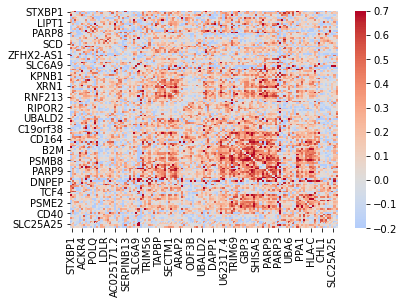

In [72]:
sns.heatmap(heatmap.iloc[order, order],cmap='coolwarm', center=0, vmin=-0.2, vmax=0.7,)

<AxesSubplot:>

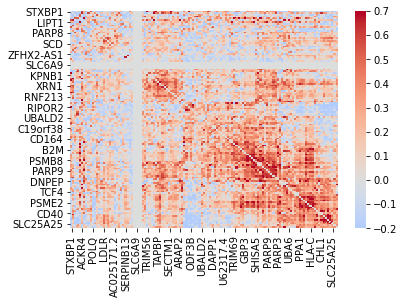

In [73]:
sns.heatmap(beta_heatmap.iloc[order, order],cmap='coolwarm', center=0, vmin=-0.2, vmax=0.7,)

In [36]:
beta_heatmap.columns[order[order.index(available_isgs.index('SLFN12')):order.index(available_isgs.index('ELF1'))]]

Index(['SLFN12', 'TRIM5', 'BISPR', 'AZI2', 'RBM43', 'CCND3', 'SCAMP1-AS1',
       'PI4K2B', 'MYD88', 'NAPA', 'EIF2AK2', 'MUC15', 'NDUFA9', 'TMEM50A',
       'IFI27', 'LYSMD2'],
      dtype='object')

In [35]:
beta_heatmap.columns[order[order.index(available_isgs.index('MT2A')):order.index(available_isgs.index('TENT5A'))]]

Index(['MT2A', 'NUPR1', 'HERC5', 'NUB1', 'TLR3', 'CAPG', 'BAG1', 'LY6E',
       'LMO2', 'LGALS3BP', 'TNFSF10', 'TXNIP', 'HES4', 'PCGF5', 'IFIT5',
       'ANKIB1'],
      dtype='object')

In [29]:
available_isgs.index('TENT5A')

148

In [28]:
available_isgs.index('MT2A')

24